# Obliczanie pierwiastków wielomianów w postaci

$f(x) = ax^3 + bx^2 + cx + d,\quad a,b,c,d \in R$


Zaczniemy od dodania potrzebnych biblotek pozwalających nam zdefiniować wielomiany w języku Julia oraz
rysować potrzebne wykresy

In [1287]:
using Polynomials
using Plots

setprecision(128)

128

Zdefinijumy sobie przykładowy wielomian: $x^3 + x^2 + x + 1$ i narysujmy jego wykres.

In [1288]:
f = fromroots([0 - 1im,0 + 1im,-1])

Polynomial(1 + x + x^2 + x^3)

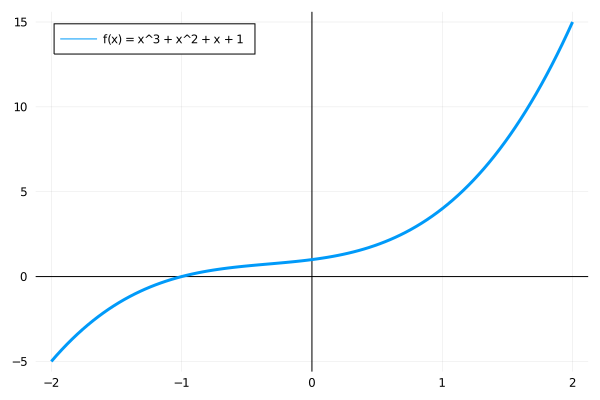

In [1289]:
default(framestyle = :zerolines)
plot(f, -2, 2, label = "f(x) = x^3 + x^2 + x + 1", linewidth = 3, legend = :topleft)

# Obliczanie wartości funkcji i pochodnych

Potrzebujemy sprawnego i szybkiego algorytmu do obliczania wartości naszych wielomianów oraz ich pochodnych pierwszego stopnia. Do tego użyjemy rozszerzonego schematu Hornera danego algorytmem:

In [1290]:
# Funkcja dla danej funkcji f i argumentu x zwróci parę (f(x0), f'(x0)).

function Horner(polynomial, x)
    n = length(polynomial) - 1
    
    f  = polynomial[n]
    ∂f = 0
    
    for i = n - 1:-1:0
        ∂f = f + x * ∂f
        f  = polynomial[i] + x * f
    end
    
    return f, ∂f
end

Horner (generic function with 1 method)

Sprawdźdmy poprawność działania algorytmu dla kilku przykładowych punktów

In [1291]:
using Printf

println("Dla x = 0: ", Horner(f, 0))
println("Dla x = 2: ", Horner(f, 2))
println("Dla x = 4: ", Horner(f, 4))

Dla x = 0: (1, 1)
Dla x = 2: (15, 17)
Dla x = 4: (85, 57)


# Dzielenie wielomianów 3 stopnia przez wielomian (x - x0)

Jest to zwykły algorytm Hornera, do dzielenia wielominaów.

In [1292]:
function divide(f, x0) 
    b = zeros(3)
    b[3] = f[3]
    
    for i = 2:-1:1
        b[i] = f[i] + x0 * b[i + 1]
    end
 
    return Polynomial(b)
end

divide (generic function with 1 method)

# Metoda wyznczania pierwiastków wielomianów kwadratowych

Przed implementacją innych metod, potrzebuję mieć algorytm numerycznie poprawny, który znajdzie pierwiastki funkcji kwadratowej. Mogę to zrobić wyznaczając wyróżnik funkcji i używając istniejących wzorów Viete'a uważając, aby nie utracić cyfr znaczących.

In [1293]:
# Funkcja, dla danej funkcji f zwróci jej pierwiastki zespolone

function solveQuadratic(f)
    a = f[2]
    b = f[1]
    c = f[0]
    
    x1 = 0
    x2 = 0
    
    Δ = b * b - 4 * a * c
    
    if (Δ > 0)
        
        if (b > 0)
            x1 = (-b - sqrt(Δ)) / (2 * a)
        else
            x1 = (-b + sqrt(Δ)) / (2 * a)
        end
        x2 = c / (a * x1)
            
    elseif (Δ == 0)        
        x1 = -b / (2 * a)        
        x2 = -b / (2 * a)
    else
        
        if (b > 0)
            x1 = (-b - sqrt(-Δ)*im) / (2 * a)
        else
            x1 = (-b + sqrt(-Δ)*im) / (2 * a)
        end
        x2 = c / (a * x1)
    end
    
    return x1, x2
end

solveQuadratic (generic function with 1 method)

In [1294]:
solveQuadratic(Polynomial([-1,0,1]))

(1.0, -1.0)

In [1295]:
solveQuadratic(Polynomial([1,0,1]))

(0.0 + 1.0im, 0.0 - 1.0im)

In [1296]:
solveQuadratic(Polynomial([5,2,3]))

(-0.3333333333333333 - 1.247219128924647im, -0.3333333333333333 + 1.2472191289246473im)

In [1297]:
roots(Polynomial([5,2,3]))

2-element Array{Complex{Float64},1}:
 -0.33333333333333337 - 1.2472191289246473im
 -0.33333333333333337 + 1.2472191289246473im

# Metoda Newtona

Poniżej znajduje się zaimplementowany algorytm metody Newtona

In [1317]:
# Funkcja dla danej funkcji f, danego punktu startowego x0 zwróci pierwiastek z dokładnością do ε.
# Oczywiście tylko jeśli x0 będzie dostatecznie tego pierwiastka.
# Ponieważ metoda może być rozbieżna ograniczę liczbę iteracji do M.

function Newton(f, x0, ε, M, print = false)
    v = Horner(f, x0)
    
    if (abs(v[1]) < ε)
        return x0
    end
    
    for i = 1:M
        x1 = x0 - v[1] / v[2]
        v = Horner(f, x1)
        
        rε = abs((x1 - x0) / x1)
        
        if print
            @printf("Iteracja: %d, x_i = %f, błąd bezwględny = %f\n", i, x1, rε)
        end
            
        if (abs(v[1]) < ε)
            x0, x2 = solveQuadratic(divide(f, x1))
            
            return x0, x1, x2
        end
        
        x0 = x1
    end
    
    x1, x2 = solveQuadratic(divide(f, x0))
            
    return x0, x1, x2
end

Newton (generic function with 3 methods)

Przetestujmy działanie algorytmu dla kilku punktów startowych dla naszej funkcji f.

In [1318]:
Newton(f, 5, 1.0e-10, 20)

(-2.0, 4.0, -0.0)

In [1319]:
Newton(f, -6, 1.0e-10, 20)

(3.999999999999885, -2.0000000000002296, 3.441691376338084e-13)

In [1320]:
Newton(f, 100, 1.0e-10, 20, true)

Iteracja: 1, x_i = 66.909976, błąd bezwględny = 0.494545
Iteracja: 2, x_i = 44.860655, błąd bezwględny = 0.491507
Iteracja: 3, x_i = 30.177345, błąd bezwględny = 0.486567
Iteracja: 4, x_i = 20.413262, błąd bezwględny = 0.478321
Iteracja: 5, x_i = 13.942050, błąd bezwględny = 0.464151
Iteracja: 6, x_i = 9.687374, błąd bezwględny = 0.439198
Iteracja: 7, x_i = 6.944775, błąd bezwględny = 0.394915
Iteracja: 8, x_i = 5.265161, błąd bezwględny = 0.319005
Iteracja: 9, x_i = 4.370694, błąd bezwględny = 0.204651
Iteracja: 10, x_i = 4.046377, błąd bezwględny = 0.080150
Iteracja: 11, x_i = 4.000871, błąd bezwględny = 0.011374
Iteracja: 12, x_i = 4.000000, błąd bezwględny = 0.000218
Iteracja: 13, x_i = 4.000000, błąd bezwględny = 0.000000


(-1.9999999999999165, 4.000000000000042, -1.2523315717772288e-13)

# Metoda bisekcji

Poniżej znajduje się zaimplementowany algorytm metody Bisekcji, wyznaczający dwa pozostałe pierwiastki przy pomocy wzorów Viete'a.

In [1321]:
# Funkcja, dla danej funkcji f, dwóch punktów startowych x0 <= x1 zwróci pierwiastek x0 z dokładnością do ε.
# Oraz pierwiastki x1, x2 policzone ze wzorów Viete'a
# Ponieważ metoda może być rozbieżna ograniczę liczbę iteracji do M.

function Bisection(f, x0, x1, ε, M, print = false)
    a = Horner(f, x0)[1]
    b = Horner(f, x1)[1]
    
    if (sign(a) == sign(b))
        return x0
    end
    
    for i = 1:M
        x2 = ((x0 + x1) / 2)
        
        v = Horner(f, x2)[1]
        
        if print
            @printf("Iteracja: %d, a = %f, b = %f, c = %f, f(c) = %f\n", i, x0, x1, x2, v)
        end
        
        if (abs(v) < ε)
            x0, x1 = solveQuadratic(divide(f, x2))
            
            return x0, x1, x2
        end
        
        if (sign(a) != sign(v))
            x1 = x2
        else
            x0 = x2
        end
    end
        
    x1, x2 = solveQuadratic(divide(f, x0))
                
    return [x0, x1, x2]
end

Bisection (generic function with 2 methods)

In [1322]:
Bisection(f, -5, 5, 1.0e-10, 20)

(4.0, -2.0, 0.0)

In [1323]:
Bisection(f, -50, 50, 1.0e-10, 20)

(4.0, -2.0, 0.0)

In [1324]:
Bisection(f, -3, 16, 1.0e-10, 20, true)

Iteracja: 1, a = -3.000000, b = 16.000000, c = 6.500000, f(c) = 138.125000
Iteracja: 2, a = -3.000000, b = 6.500000, c = 1.750000, f(c) = -14.765625
Iteracja: 3, a = 1.750000, b = 6.500000, c = 4.125000, f(c) = 3.158203
Iteracja: 4, a = 1.750000, b = 4.125000, c = 2.937500, f(c) = -15.410400
Iteracja: 5, a = 2.937500, b = 4.125000, c = 3.531250, f(c) = -9.155731
Iteracja: 6, a = 3.531250, b = 4.125000, c = 3.828125, f(c) = -3.834667
Iteracja: 7, a = 3.828125, b = 4.125000, c = 3.976563, f(c) = -0.557020
Iteracja: 8, a = 3.976563, b = 4.125000, c = 4.050781, f(c) = 1.244668
Iteracja: 9, a = 3.976563, b = 4.050781, c = 4.013672, f(c) = 0.329997
Iteracja: 10, a = 3.976563, b = 4.013672, c = 3.995117, f(c) = -0.116949
Iteracja: 11, a = 3.995117, b = 4.013672, c = 4.004395, f(c) = 0.105662
Iteracja: 12, a = 3.995117, b = 4.004395, c = 3.999756, f(c) = -0.005859
Iteracja: 13, a = 3.999756, b = 4.004395, c = 4.002075, f(c) = 0.049848
Iteracja: 14, a = 3.999756, b = 4.002075, c = 4.000916, f(c

3-element Array{Float64,1}:
  3.9999914169311523
 -2.000017165879859
  2.5748948706753332e-5

# Metoda Bairstowa

Poniżej znajduje się zaimplementowany algorytm metody Bairstowa.

In [1325]:
# Funkcja, dla danej funkcji f, startowych przybliżeń v, u zwraca wszystkie pierwiastki 
# wielomianu trzeciego stopnia. Maksymalna liczba iteracji to M. 

function Bairstow(f, u, v, M)
    n = length(f)
    
    b = zeros(n)
    c = zeros(n)
    
    b[n] = f[n - 1]
    c[n - 1] = f[n - 1]
    
    for j = 1:M
        b[n-1] = f[n - 2] + u * b[n]
        for k = n - 2:-1:1
            b[k] = f[k - 1] + u * b[k + 1] + v * b[k + 2]
            c[k] = b[k + 1] + u * c[k + 1] + v * c[k + 2]
        end
        
        J = c[1] * c[3] - c[2] * c[2]
        u = u + (c[2] * b[2] - c[3] * b[1]) / J
        v = v + (c[2] * b[1] - c[1] * b[2]) / J
    end
    
    quadratic = Polynomial([-v, -u, 1])
    x0, x1 = solveQuadratic(quadratic)
    
    if (x0 != 0 && x1 != 0)
        x2 = -f[0] / (f[3] * x0 * x1)
    else
        x2 = -f[2] / f[3] - x0 - x1
    end
    
    return [x0, x1, x2]
    
end

Bairstow (generic function with 2 methods)

In [1326]:
Bairstow(f, 1, 1, 40)

3-element Array{Float64,1}:
 -2.0
  0.0
  4.0

In [1327]:
roots(f)

3-element Array{Float64,1}:
 -2.0
  4.0
  0.0

In [1328]:
Bairstow(f, -0.5, -0.5, 40)

3-element Array{Float64,1}:
 -2.0
  0.0
  4.0

# Wzory Cardano

In [1383]:
function Cardano(f)
    a = f[3]
    b = f[2]
    c = f[1]
    d = f[0]
    
    Q = (3 * a * c - b * b) / (9 * a * a)
    R = (9 * a * b * c - 27 * a * a * d - 2 * b * b * b) / (54 * a * a * a)
    
    discriminant = Q * Q * Q + R * R
    S = 0
    T = 0
    
    if (discriminant >= 0)
        S = cbrt(R + sqrt(discriminant))
        T = cbrt(R - sqrt(discriminant))
    else
        S = (R + sqrt(discriminant + 0im))^(1/3)
        T = (R - sqrt(discriminant + 0im))^(1/3)
    end
    
    x0 = S + T - b / (3 * a)
    x1 = -(S + T) / 2 - b / (3 * a) + (im * sqrt(3)) / 2 * (S - T)
    x2 = -(S + T) / 2 - b / (3 * a) - (im * sqrt(3)) / 2 * (S - T)
    
    return [x0, x1, x2]
end

Cardano (generic function with 1 method)

In [1330]:
Cardano(f)

dsa

(4.0 + 0.0im, -2.0 + 0.0im, 0.0 - 0.0im)

# Testy numeryczne

Zaimplementowałem trzy różne metody szukania pierwiastków wielomianów trzeciego stopnia. Ponieważ metoda Newtona i bisekcji potrzebują mieć sensowne dane wejściowe, aby znaleźć chociaż jeden pierwiastek, to pokażę jak szybko i z jakim błędem są w stanie go znaleźć, a potem używając schematu Hornera wyznacze pozostałe dwa pierwiastki. Na początek kilka testów przygotowanych, a później kilka wielomianów wylosowanych za pomocą Julii.

Zdefiniowałem cztery funkcje testujące dla każdej metody. Wszystkie pokazują ile cyfr znaczących wyznaczyły dobrze.

In [1331]:
# Wyświetla ilość cyfr znaczących

function TestBairstow(f, v, u, MaxM, r1, r2, r3)
    
    function significantDigits(x)
        if (x == 0)
            return 20
        end
        
        return min(20, max(0, round(-log10(abs(x)))))
    end
    
    x0 = zeros(MaxM)
    x1 = zeros(MaxM)
    x2 = zeros(MaxM)
    
    for i = 1:MaxM
        b = Bairstow(f, u, v, i)
    
        x0[i] = significantDigits(abs(r1 - b[1]))
        x1[i] = significantDigits(abs(r2 - b[2]))
        x2[i] = significantDigits(abs(r3 - b[3]))        
    end    
    
    default(framestyle = :zerolines)
    plot([x0, x1, x2], label = ["x0" "x1" "x2"], 
        linewidth = 3, xlabel = "Iteracja", ylabel="Liczba cyfr znaczących", legend = :topleft)    
end

TestBairstow (generic function with 1 method)

In [1358]:
# Wyświetla ilość cyfr znaczących

function TestNewton(f, x_0, ε, MaxM, r1, r2, r3)
    
    function significantDigits(x)
        if (x == 0)
            return 20
        end
        
        return min(20, max(0, round(-log10(abs(x)))))
    end
    
    x0 = zeros(MaxM)
    x1 = zeros(MaxM)
    x2 = zeros(MaxM)
    
    for i = 1:MaxM
        b = Newton(f, x_0, ε, i)
    
        x0[i] = significantDigits(abs(r1 - b[1]))
        x1[i] = significantDigits(abs(r2 - b[2]))
        x2[i] = significantDigits(abs(r3 - b[3]))        
    end    
    
    default(framestyle = :zerolines)
    plot([x0, x1, x2], label = ["x0" "x1" "x2"], 
        linewidth = 3, xlabel = "Iteracja", ylabel="Liczba cyfr znaczących", legend = :topleft)    
end

TestNewton (generic function with 1 method)

In [1362]:
# Wyświetla ilość cyfr znaczących

function TestBisection(f, x_0, x_1, ε, MaxM, r1, r2, r3)
    
    function significantDigits(x)
        if (x == 0)
            return 20
        end
        
        return min(20, max(0, round(-log10(abs(x)))))
    end
    
    x0 = zeros(MaxM)
    x1 = zeros(MaxM)
    x2 = zeros(MaxM)
    
    for i = 1:MaxM
        b = Bisection(f, x_0, x_1, ε, i)
    
        x0[i] = significantDigits(abs(r1 - b[1]))
        x1[i] = significantDigits(abs(r2 - b[2]))
        x2[i] = significantDigits(abs(r3 - b[3]))        
    end    
    
    default(framestyle = :zerolines)
    plot([x0, x1, x2], label = ["x0" "x1" "x2"], 
        linewidth = 3, xlabel = "Iteracja", ylabel="Liczba cyfr znaczących", legend = :topleft)    
end

TestBisection (generic function with 1 method)

In [1377]:
function TestCardano(f, r1, r2, r3)
    
    x = Cardano(f)
    
    println("Błąd względny x0: ", abs(x[1] - r1))
    println("Błąd względny x1: ", abs(x[2] - r2))
    println("Błąd względny x2: ", abs(x[3] - r3))
    
end

TestCardano (generic function with 1 method)

### Test 1

Na początek prosta funkcja

##### $f(x) = x^3 - 2x^2 - 8x$

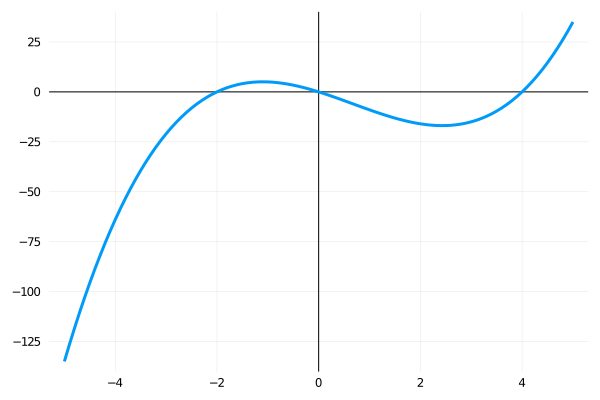

In [1378]:
f = fromroots([-2, 0, 4])

default(framestyle = :zerolines)

M = 15
ε = 1.0e-10

plot(f, -5, 5, linewidth = 3, label = false)

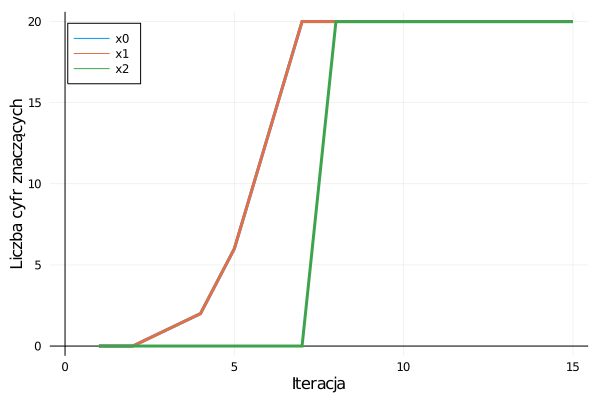

In [1379]:
TestBairstow(f, 0.1, 0.1, M, -2, 0, 4)

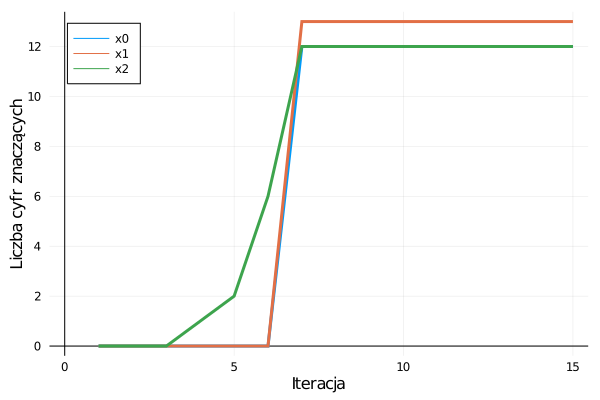

In [1380]:
TestNewton(f, 10, ε, M, -2, 4, 0)

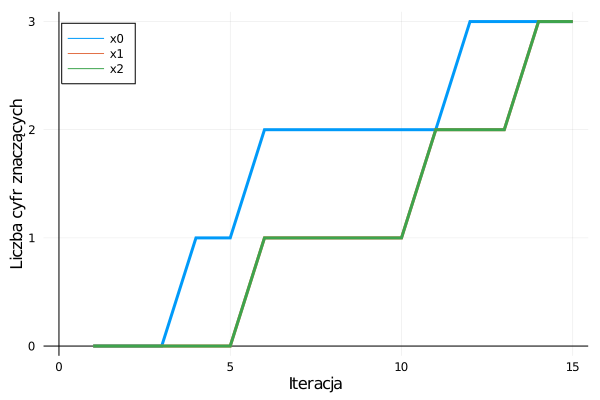

In [1381]:
TestBisection(f, 15, -4, ε, M, 4, -2, 0)

In [1382]:
TestCardano(f, 4, -2, 0)

dsaBłąd względny x0: 0.0
Błąd względny x1: 0.0
Błąd względny x2: 0.0
